In [17]:
from sklearn.preprocessing import LabelBinarizer
import keras, pickle, numpy as np
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Activation, Concatenate, Dropout, Flatten, Dense

import pickle
import numpy as np

## Conver Raw Data

In [4]:
p = pickle.load( open( "experimental_data/experimental_data2.out", "rb" ) )
p2 = pickle.load( open( "experimental_data/experimental_data3.out", "rb" ) )

#fac = 120/10
#shift = np.array([2.5,2.5,2.5]) 

fac = 12
shift = np.array([2.5, 2.5, 2.5]) 

a, b, c = 0, 3, 2

poplist_1 = [fac*np.array([[ind[0] for ind in e] for e in exp[1][a:b:c]]-shift)for exp in p[:]]
fitlist_1 = [np.array([[ind[1] for ind in e] for e in exp[1][a:b:c]]) for exp in p[:]]

poplist_2 = [fac*np.array([[ind[0] for ind in e] for e in exp[1][a:b:c]]-shift) for exp in p2[:]]
fitlist_2 = [np.array([[ind[1] for ind in e] for e in exp[1][a:b:c]]) for exp in p2[:]]


with open('experimental_data/experiment-populations.out', 'wb') as fp:
    pickle.dump(poplist_1, fp)
    
with open('experimental_data/experiment-populations2.out', 'wb') as fp:
    pickle.dump(poplist_2, fp)
    
with open('experimental_data/experiment-fitnesses.out', 'wb') as fp:
    pickle.dump(fitlist_1, fp)
    
with open('experimental_data/experiment-fitnesses2.out', 'wb') as fp:
    pickle.dump(fitlist_2, fp)

## Load Histogram Data Format

In [18]:
populations = pickle.load( open( "histogram_data/histogram-experiment-populations.out", "rb" ) )[:]
populations2 = pickle.load( open( "histogram_data/histogram-experiment-populations2.out", "rb" ) )[:]

In [19]:
def extractConfiguration(input_p):

    params = []

    for exp in input_p:    
        popmins = exp[0]
        pmins = [x[1] for x in popmins]
        deltas = [pmins[i]-pmins[i+1] for i in range(0,len(pmins)-1)]
        idx = np.argmax(deltas)
        
        mat = exp[2][idx]
        triu = [mat[0][0],mat[1][1],mat[2][2]] + [mat[0][1],mat[1][2],mat[0][2]]
        params.append([np.array(triu), np.array(exp[3][idx])])
    
    return params

def constructCovariance(inputs):

    ind, ino = inputs[:3], inputs[3:]    
    diag = np.array([[ind[0],0,0],[0,ind[1],0],[0,0,ind[2]]])
    offdiag = np.array([[0,ino[0],ino[2]],[0,0,ino[1]],[0,0,0]])
    
    return offdiag+offdiag.T+diag

In [64]:
c = p[0][2][0]
ch = np.linalg.cholesky(c)
np.dot(ch,ch.T), c

(array([[ 1.16469163,  0.12900352, -0.20256557],
        [ 0.12900352,  0.8570153 ,  0.04847534],
        [-0.20256557,  0.04847534,  1.04413126]]),
 [[1.164691627328208, 0.1290035195123651, -0.202565574638533],
  [0.12900351951236513, 0.857015300938707, 0.04847534291680289],
  [-0.202565574638533, 0.04847534291680289, 1.04413125986332]])

In [20]:
labels1 = extractConfiguration(p)
labels2 = extractConfiguration(p2)

In [21]:
p[0][2][5]

[[0.4473324315700158, -0.015536822050462248, -0.29181548244299677],
 [-0.015536822050462237, 0.7262657980928822, 0.7171203517823396],
 [-0.29181548244299677, 0.7171203517823395, 1.6428633244233033]]

In [22]:
labels1[0]

[array([ 0.44733243,  0.7262658 ,  1.64286332, -0.01553682,  0.71712035,
        -0.29181548]), array(1.61333797)]

In [23]:
from sklearn.preprocessing import LabelBinarizer

X = []
y = [[], []]

for a,b,y1,y2 in zip(populations, populations2, labels1, labels2):

    X.append(a[0]), X.append(b[0])
    y[0].append(y1[0]), y[1].append(y1[1])
    y[0].append(y2[0]), y[1].append(y2[1])
    #y.append(0), y.append(1)

X_train, Y_train = np.array(X), y
#X_train, y_train = np.array(X[:3200]), np.array(y[:3200])
#X_test, y_test = np.array(X[-800:]), np.array(y[-800:])


In [211]:
# Configuration options
input_vector_length = 1*100

accs = []
#for i in range(0,1):
# Create the model
# 200, 10, 50, 4
in_x = Input(shape=(input_vector_length,))
x = Dense(10, activation='relu')(in_x)
x = Dense(200, activation='relu')(x)
out_diag = Dense(3, activation='exponential')(x)
out_offdiag = Dense(3, activation='linear')(x)
out_cov = Concatenate()([out_diag, out_offdiag])

out_sigma = Dense(1, activation='relu')(x)

model = Model(inputs=in_x, outputs=[out_cov, out_sigma])

# Configure the model and start training
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mse'])

h = model.fit(X_train, Y_train, epochs=1000, batch_size=250, verbose=0, validation_split=0.2)
# inter_output_model = Model(model.input, model.layers[1].output )
#h.history['val_acc'][-1]

In [212]:
keys = list(h.history.keys())
val1, val2 = h.history[keys[1]], h.history[keys[2]]
acc1, acc2 = h.history[keys[3]], h.history[keys[4]]

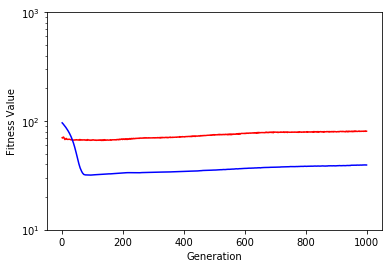

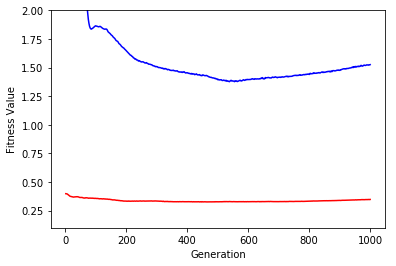

In [222]:
import matplotlib.pyplot as plt


ylmt=[10**1,10**3]
x = np.array(range(1,1+len(val1)))

plt.figure()
plt.ylim(ylmt[0],ylmt[1])
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.semilogy(x, val1, 'red')
#plt.plot(x, np.array(pm[:]).T, 'red', alpha=.25)
plt.semilogy(x, val2, 'blue')
#plt.plot(x, np.array(pm2[:]).T, 'lightblue', alpha=.25)
#plt.plot(x, np.array(pm2[10:20]).T, 'green', alpha=1.)

plt.show()


ylmt=[10**-1,2*10**0]
x = np.array(range(1,1+len(val1)))

plt.figure()
plt.ylim(ylmt[0],ylmt[1])
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.plot(x, acc1, 'red')
#plt.plot(x, np.array(pm[:]).T, 'red', alpha=.25)
plt.plot(x, acc2, 'blue')
#plt.plot(x, np.array(pm2[:]).T, 'lightblue', alpha=.25)
#plt.plot(x, np.array(pm2[10:20]).T, 'green', alpha=1.)



plt.show()

In [230]:
X_test = np.array([p[0] for p in populations[80:]])
pars = model.predict(X_test[:])
np.mean(pars[0],axis=0)

array([0.89826506, 0.9245373 , 1.2950895 , 0.01633981, 0.04137214,
       0.08569376], dtype=float32)

In [225]:
X_test = np.array([p[0] for p in populations2[80:]])
pars = model.predict(X_test[:])
np.mean(pars[0],axis=0)

array([ 1.0530548 ,  1.0690125 ,  0.8755808 ,  0.28566927, -0.03072787,
       -0.0228493 ], dtype=float32)

In [15]:
out_path_h = "prediction-model.out"

#with open(out_path_h, 'wb') as fp:
#    pickle.dump(model, fp)

In [16]:
model2 = pickle.load(open(out_path_h, "rb"))


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [41]:
cov_out = model2.predict(X_train[:])
covs = [constructCovariance(c) for c in cov_out[0]]

In [45]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) >= 0)

In [46]:
for c in covs:
    print(is_pos_def(c))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
